<a href="https://colab.research.google.com/github/lazysimon/NYCDSA_CapstoneProject/blob/master/movies_knn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import time

# data science imports
import math
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from urllib.request import urlopen

# utils import
!pip install fuzzywuzzy
from fuzzywuzzy import fuzz

# visualization imports
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

%matplotlib inline

/usr/local/lib/python3.6/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [0]:
def read_the_dat(filepath):
    with urlopen(filepath) as raw_data:
        datfileL=pd.DataFrame(l.decode("utf-8").rstrip().split('::') for l in raw_data)
    return datfileL

In [0]:
def read_the_dat2(filepath):
    with urlopen(filepath) as raw_data:
        datfileL=pd.DataFrame(l.decode("utf-8").rstrip().split('::') for l in raw_data)['movieID'].astype('str')
    return datfileL

In [10]:
movie_fname = 'https://raw.githubusercontent.com/lazysimon/NYCDSA_CapstoneProject/master/latest/movies.dat'
df_movies = read_the_dat(movie_fname)
df_movies.columns = ['movieID', 'title', 'genres']
df_movies['movieID'] = df_movies['movieID'].astype(int)
df_movies.head()

,movieID,title,genres
0,8,Edison Kinetoscopic Record of a Sneeze (1894),Documentary|Short
1,10,La sortie des usines Lumière (1895),Documentary|Short
2,12,The Arrival of a Train (1896),Documentary|Short
3,25,The Oxford and Cambridge University Boat Race ...,
4,91,Le manoir du diable (1896),Short|Horror


In [11]:
rating_fname = 'https://raw.githubusercontent.com/lazysimon/NYCDSA_CapstoneProject/master/latest/ratings.dat'
df_ratings = read_the_dat(rating_fname)
df_ratings.columns = ['userID', 'movieID', 'rating', 'timestamp']
df_ratings['userID'] = df_ratings['userID'].astype(int)
df_ratings['movieID'] = df_ratings['movieID'].astype(int)
df_ratings['rating'] = df_ratings['rating'].astype(int)
df_ratings['timestamp'] = df_ratings['timestamp'].astype(int)
df_ratings.head()

,userID,movieID,rating,timestamp
0,1,111161,10,1373234211
1,1,117060,7,1373415231
2,1,120755,6,1373424360
3,1,317919,6,1373495763
4,1,454876,10,1373621125


In [0]:
len(df_ratings.userID.unique())

59168

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd4e8f09b00>]],
      dtype=object)

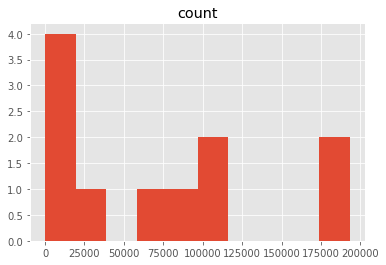

In [0]:
rating_tmp = pd.DataFrame(df_ratings.groupby('rating').size(), columns=['count'])
rating_tmp.hist()

In [0]:

# get count
df_ratings_cnt_tmp = pd.DataFrame(df_ratings.groupby('rating').size(), columns=['count'])
df_ratings_cnt_tmp

,count
rating,
0,237
1,9533
2,8213
3,13695
4,25105
5,60047
6,105219
7,180688
8,193298


In [0]:
num_users = len(df_ratings.userID.unique())
num_items = len(df_ratings.movieID.unique())
print('There are {} unique users and {} unique movies in this data set'.format(num_users, num_items))

There are 59168 unique users and 33999 unique movies in this data set


In [0]:
# there are a lot more counts in rating of zero
total_cnt = num_users * num_items
rating_zero_cnt = total_cnt - df_ratings.shape[0]
# append counts of zero rating to df_ratings_cnt
df_ratings_cnt = df_ratings_cnt_tmp.append(
    pd.DataFrame({'count': rating_zero_cnt}, index=[0.0]),
    verify_integrity=True,
).sort_index()
df_ratings_cnt

ValueError: ignored

In [0]:
# add log count
df_ratings_cnt = df_ratings_cnt_tmp.copy()
df_ratings_cnt['log_count'] = np.log(df_ratings_cnt['count'])
df_ratings_cnt

,count,log_count
rating,,
0,237,5.468060
1,9533,9.162515
2,8213,9.013474
3,13695,9.524786
4,25105,10.130822
5,60047,11.002883
6,105219,11.563799
7,180688,12.104527
8,193298,12.171988


Text(0, 0.5, 'number of ratings')

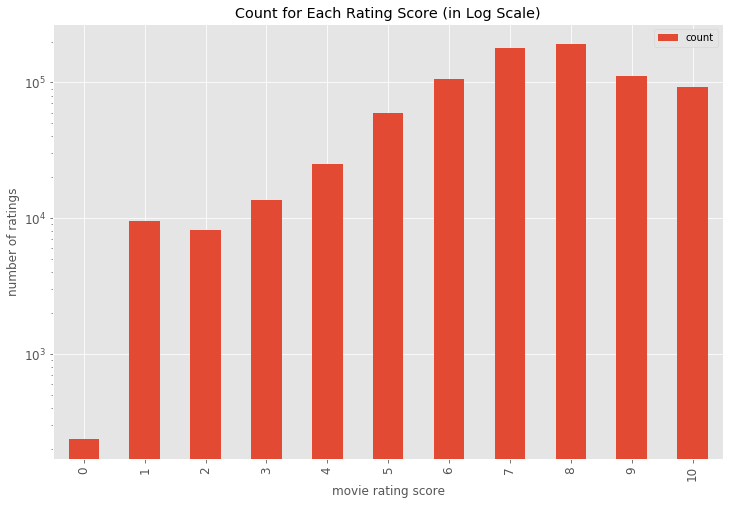

In [0]:
ax = df_ratings_cnt[['count']].reset_index().rename(columns={'rating': 'rating score'}).plot(
    x='rating score',
    y='count',
    kind='bar',
    figsize=(12, 8),
    title='Count for Each Rating Score (in Log Scale)',
    logy=True,
    fontsize=12,
)
ax.set_xlabel("movie rating score")
ax.set_ylabel("number of ratings")

In [0]:
df_ratings.head()

,userID,movieID,rating,timestamp
0,1,111161,10,1373234211
1,1,117060,7,1373415231
2,1,120755,6,1373424360
3,1,317919,6,1373495763
4,1,454876,10,1373621125


In [0]:
# get rating frequency
df_movies_cnt = pd.DataFrame(df_ratings.groupby('movieID').size(), columns=['count'])
df_movies_cnt.head(20)

,count
movieID,
8,1
10,1
12,1
25,1
91,3
131,1
417,22
439,6
443,1


Text(0, 0.5, 'number of ratings')

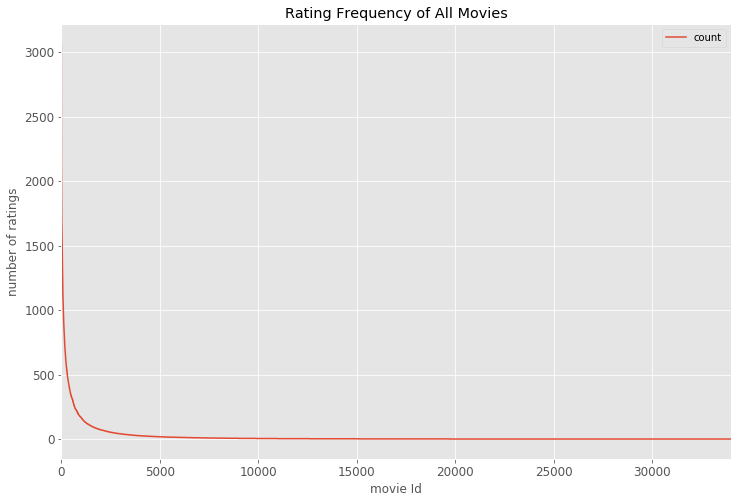

In [0]:

# plot rating frequency of all movies
ax = df_movies_cnt \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(12, 8),
        title='Rating Frequency of All Movies',
        fontsize=12
    )
ax.set_xlabel("movie Id")
ax.set_ylabel("number of ratings")

Text(0, 0.5, 'number of ratings (log scale)')

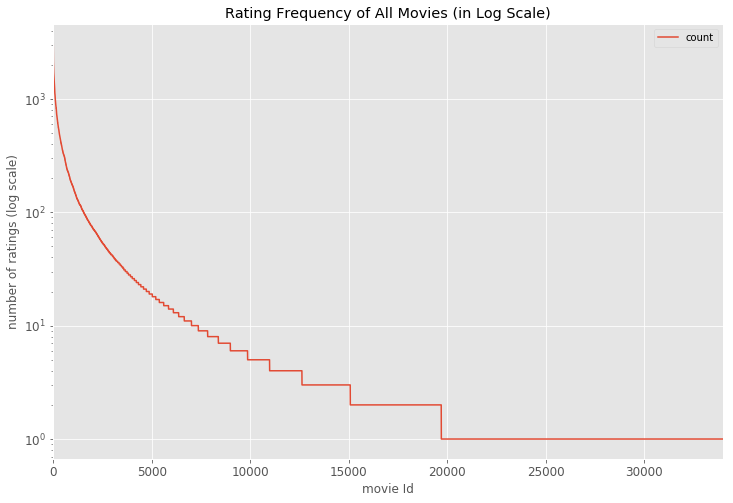

In [0]:

# plot rating frequency of all movies in log scale
ax = df_movies_cnt \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(12, 8),
        title='Rating Frequency of All Movies (in Log Scale)',
        fontsize=12,
        logy=True
    )
ax.set_xlabel("movie Id")
ax.set_ylabel("number of ratings (log scale)")

In [0]:
df_movies_cnt['count'].quantile(np.arange(1, 0.1, -0.05))

1.00    3065.0
0.95      89.0
0.90      34.0
0.85      18.0
0.80      11.0
0.75       7.0
0.70       5.0
0.65       4.0
0.60       3.0
0.55       2.0
0.50       2.0
0.45       2.0
0.40       1.0
0.35       1.0
0.30       1.0
0.25       1.0
0.20       1.0
0.15       1.0
Name: count, dtype: float64

In [0]:

# filter data
popularity_thres = 8
popular_movies = list(set(df_movies_cnt.query('count >= @popularity_thres').index))
df_ratings_drop_movies = df_ratings[df_ratings.movieID.isin(popular_movies)]
print('shape of original ratings data: ', df_ratings.shape)
print('shape of ratings data after dropping unpopular movies: ', df_ratings_drop_movies.shape)

shape of original ratings data:  (801291, 4)
shape of ratings data after dropping unpopular movies:  (748708, 4)


In [0]:
# get number of ratings given by every user
df_users_cnt = pd.DataFrame(df_ratings_drop_movies.groupby('userID').size(), columns=['count'])
df_users_cnt.head()

,count
userID,
1,19
2,23
3,3
4,1
5,2


Text(0, 0.5, 'number of ratings')

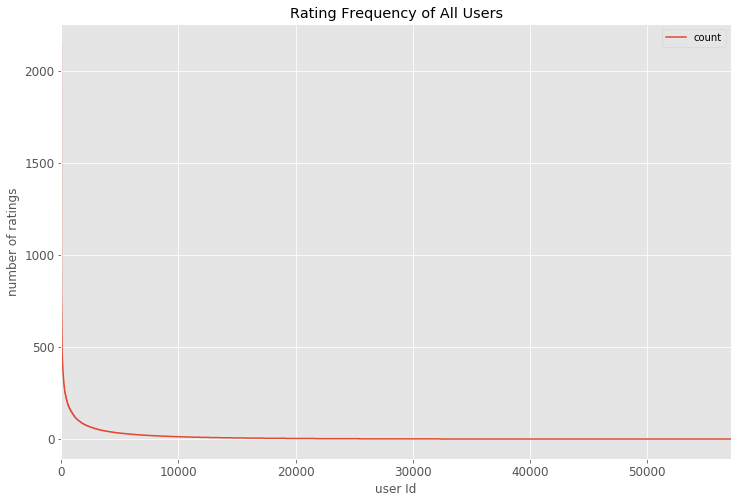

In [0]:

# plot rating frequency of all movies
ax = df_users_cnt \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(12, 8),
        title='Rating Frequency of All Users',
        fontsize=12
    )
ax.set_xlabel("user Id")
ax.set_ylabel("number of ratings")

In [0]:
df_users_cnt['count'].quantile(np.arange(1, 0.5, -0.05))

1.00    2146.0
0.95      58.0
0.90      28.0
0.85      17.0
0.80      11.0
0.75       8.0
0.70       6.0
0.65       4.0
0.60       3.0
0.55       2.0
Name: count, dtype: float64

In [0]:
# filter data
ratings_thres = 10
active_users = list(set(df_users_cnt.query('count >= @ratings_thres').index))
df_ratings_drop_users = df_ratings_drop_movies[df_ratings_drop_movies.userID.isin(active_users)]
print('shape of original ratings data: ', df_ratings.shape)
print('shape of ratings data after dropping both unpopular movies and inactive users: ', df_ratings_drop_users.shape)

shape of original ratings data:  (801291, 4)
shape of ratings data after dropping both unpopular movies and inactive users:  (645353, 4)


In [0]:
df_ratings_drop_users.head(5)

,userID,movieID,rating,timestamp
0,1,111161,10,1373234211
1,1,117060,7,1373415231
2,1,120755,6,1373424360
3,1,317919,6,1373495763
4,1,454876,10,1373621125


In [0]:

# pivot and create movie-user matrix
movie_user_mat = df_ratings_drop_users.pivot(index='movieID', columns='userID', values='rating').fillna(0)
# create mapper from movie title to index
movie_to_idx = {
    movie: i for i, movie in 
    enumerate(list(df_movies.set_index('movieID').loc[movie_user_mat.index].title))
}
# transform matrix to scipy sparse matrix
movie_user_mat_sparse = csr_matrix(movie_user_mat.values)

In [0]:
%env JOBLIB_TEMP_FOLDER=/tmp
# define model
model_knn = NearestNeighbors(metric='euclidean', algorithm='brute', n_neighbors=10, n_jobs=-1)
# fit
model_knn.fit(movie_user_mat_sparse)

env: JOBLIB_TEMP_FOLDER=/tmp


NearestNeighbors(algorithm='brute', leaf_size=30, metric='euclidean',
                 metric_params=None, n_jobs=-1, n_neighbors=10, p=2,
                 radius=1.0)

In [0]:
def fuzzy_matching(mapper, fav_movie, verbose=True):
    """
    return the closest match via fuzzy ratio. If no match found, return None
    
    Parameters
    ----------    
    mapper: dict, map movie title name to index of the movie in data

    fav_movie: str, name of user input movie
    
    verbose: bool, print log if True

    Return
    ------
    index of the closest match
    """
    match_tuple = []
    # get match
    for title, idx in mapper.items():
        ratio = fuzz.ratio(title.lower(), fav_movie.lower())
        if ratio >= 60:
            match_tuple.append((title, idx, ratio))
    # sort
    match_tuple = sorted(match_tuple, key=lambda x: x[2])[::-1]
    if not match_tuple:
        print('Oops! No match is found')
        return
    if verbose:
        print('Found possible matches in our database: {0}\n'.format([x[0] for x in match_tuple]))
    return match_tuple[0][1]
  
def make_recommendation(model_knn, data, mapper, fav_movie, n_recommendations):
    """
    return top n similar movie recommendations based on user's input movie


    Parameters
    ----------
    model_knn: sklearn model, knn model

    data: movie-user matrix

    mapper: dict, map movie title name to index of the movie in data

    fav_movie: str, name of user input movie

    n_recommendations: int, top n recommendations

    Return
    ------
    list of top n similar movie recommendations
    """
    # fit
    model_knn.fit(data)
    # get input movie index
    print('You have input movie:', fav_movie)
    idx = fuzzy_matching(mapper, fav_movie, verbose=True)
    # inference
    print('Recommendation system start to make inference')
    print('......\n')
    distances, indices = model_knn.kneighbors(data[idx], n_neighbors=n_recommendations+1)
    # get list of raw idx of recommendations
    raw_recommends = \
        sorted(list(zip(indices.squeeze().tolist(), distances.squeeze().tolist())), key=lambda x: x[1])[:0:-1]
    # get reverse mapper
    reverse_mapper = {v: k for k, v in mapper.items()}
    # print recommendations
    print('Recommendations for {}:'.format(fav_movie))
    for i, (idx, dist) in enumerate(raw_recommends):
        print('{0}: {1}, with distance of {2}'.format(i+1, reverse_mapper[idx], dist))

In [0]:
my_favorite = 'Titanic'

make_recommendation(
    model_knn=model_knn,
    data=movie_user_mat_sparse,
    fav_movie=my_favorite,
    mapper=movie_to_idx,
    n_recommendations=10)

You have input movie: Titanic
Found possible matches in our database: ['Titanic (1997)']

Recommendation system start to make inference
......

Recommendations for Titanic:
1: Obvious Child (2014), with distance of 49.22397789695587
2: Iverson (2014), with distance of 49.17316341257699
3: Better Watch Out (2016), with distance of 49.03060268852505
4: Jolly LLB 2 (2017), with distance of 49.01020301937138
5: Tyler Perry's Temptation (2013), with distance of 48.7134478352744
6: Be Kind Rewind (2008), with distance of 48.662100242385755
7: Highlander II: The Quickening (1991), with distance of 48.373546489791295
8: First Man (2018), with distance of 47.853944456021594
9: The Count of Monte Cristo (2002), with distance of 47.22287581247038
10: The Ninth Gate (1999), with distance of 44.05678154382138


In [0]:
def changeencode(data, cols):
    for col in cols:
        data[col] = data[col].str.decode('iso-8859-1').str.encode('utf-8')
    return data  

In [0]:
def read_dat_latin(filepath):
    with urlopen(filepath) as raw_data:
        datfileL=pd.DataFrame(l.decode("latin-1").rstrip().split('::') for l in raw_data)
    return datfileL

In [0]:
mvlens_fname = 'https://github.com/lazysimon/NYCDSA_CapstoneProject/raw/master/ml-1m/movies.dat'
df_mvlens = read_dat_latin(mvlens_fname)
df_mvlens.columns = ['movieID', 'title', 'genres']
df_mvlens['movieID'] = df_mvlens['movieID'].astype(int)
print(df_movies.head())
df_mvlens.head()

   movieID  ...             genres
0        8  ...  Documentary|Short
1       10  ...  Documentary|Short
2       12  ...  Documentary|Short
3       25  ...                   
4       91  ...       Short|Horror

[5 rows x 3 columns]


,movieID,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [0]:
mvlens_fn10m = 'https://github.com/lazysimon/NYCDSA_CapstoneProject/raw/master/movies.dat'
df_mv10mlens =read_dat_latin(mvlens_fn10m)
df_mv10mlens.columns=['movieID','title','genres']
print(df_mv10mlens.head())
print(df_mv10mlens.shape)
df_mv10mlens.info()

  movieID  ...                                       genres
0       1  ...  Adventure|Animation|Children|Comedy|Fantasy
1       2  ...                   Adventure|Children|Fantasy
2       3  ...                               Comedy|Romance
3       4  ...                         Comedy|Drama|Romance
4       5  ...                                       Comedy

[5 rows x 3 columns]
(10681, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10681 entries, 0 to 10680
Data columns (total 3 columns):
movieID    10681 non-null object
title      10681 non-null object
genres     10681 non-null object
dtypes: object(3)
memory usage: 250.4+ KB


In [0]:
print(type(df_movies))
print(type(df_mvlens))
print(df_movies.shape)
print(df_mvlens.shape)
df_mvlens.info()

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
(34000, 3)
(3883, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3883 entries, 0 to 3882
Data columns (total 3 columns):
movieID    3883 non-null int64
title      3883 non-null object
genres     3883 non-null object
dtypes: int64(1), object(2)
memory usage: 91.1+ KB


In [0]:
df_merge = pd.merge(df_movies, df_mvlens, on='title', how='outer')
print(df_merge.shape)
df_merge.head(10)

(1825, 5)


,movieID_x,title,genres_x,movieID_y,genres_y
0,16332,Seven Chances (1925),Comedy|Romance,3232,Comedy
1,17423,Sparrows (1926),Drama,2957,Drama
2,17825,Downhill (1927),Adventure|Drama|Thriller,2224,Drama
3,18578,Wings (1927),Drama|Romance|War|Action,1925,Drama|Romance|War
4,19702,Blackmail (1929),Crime|Thriller,2221,Thriller
5,20629,All Quiet on the Western Front (1930),Drama|War,1927,War
6,21165,Murder! (1930),Crime|Mystery|Thriller,2219,Mystery|Thriller
7,21746,Cimarron (1931),Drama|Western,1928,Western
8,21749,City Lights (1931),Comedy|Drama|Romance,3307,Comedy|Drama|Romance
9,21814,Dracula (1931),Fantasy|Horror,2644,Horror


In [0]:
df_merge2 = pd.merge(df_movies, df_mv10mlens, on='title', how='outer')
print(df_merge2.shape)
df_merge2.head(10)

(39879, 5)


,movieID_x,title,genres_x,movieID_y,genres_y
0,8.0,Edison Kinetoscopic Record of a Sneeze (1894),Documentary|Short,NaN,NaN
1,10.0,La sortie des usines Lumière (1895),Documentary|Short,NaN,NaN
2,12.0,The Arrival of a Train (1896),Documentary|Short,NaN,NaN
3,25.0,The Oxford and Cambridge University Boat Race ...,,NaN,NaN
4,91.0,Le manoir du diable (1896),Short|Horror,NaN,NaN
5,131.0,Une nuit terrible (1896),Short|Comedy|Horror,NaN,NaN
6,417.0,Le voyage dans la lune (1902),Short|Action|Adventure|Comedy|Fantasy|Sci-Fi,NaN,NaN
7,439.0,The Great Train Robbery (1903),Short|Action|Crime|Western,NaN,NaN
8,443.0,"Hiawatha, the Messiah of the Ojibway (1903)",,NaN,NaN
9,628.0,The Adventures of Dollie (1908),Action|Short,NaN,NaN


# Implicit ratings

In [50]:
movieDF = pd.read_csv(movie_fname, sep='::', header='infer', skipinitialspace=True,names = ["MovieId","Movie_Title","Genres"])
movieDF = movieDF.drop('Genres', 1)
# movieDF[['movie', 'year']] = movieDF['Movie_Title'].str.split('(',expand=True)
# movieDF[['year', 'del']] = movieDF['year'].str.split(')',expand=True)
# movieDF = movieDF.drop('del',1)
# movieDF=movieDF.drop('Movie_Title',1)
ratingDF = pd.read_csv(rating_fname, sep='::', header='infer', skipinitialspace=True,names = ["UserId", "MovieId", "Rating", "Timestamp"])
ratingDF = ratingDF.drop('Timestamp',1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  import sys


In [17]:
mergeDF = pd.merge(movieDF, ratingDF, on="MovieId",how="left")
mergeDF['scaled']=np.sign(ratingDF.Rating - 5) ##definitely wrong. needs rework with sigmoid or sth
mergeDF.head(10)

,MovieId,movie,year,UserId,Rating,scaled
0,8,Edison Kinetoscopic Record of a Sneeze,1894,44332,5,1.0
1,10,La sortie des usines Lumière,1895,53331,10,1.0
2,12,The Arrival of a Train,1896,42626,10,1.0
3,25,The Oxford and Cambridge University Boat Race,1895,33883,8,1.0
4,91,Le manoir du diable,1896,10257,7,1.0
5,91,Le manoir du diable,1896,10677,6,1.0
6,91,Le manoir du diable,1896,36202,5,1.0
7,131,Une nuit terrible,1896,34233,7,1.0
8,417,Le voyage dans la lune,1902,508,10,0.0
9,417,Le voyage dans la lune,1902,3249,10,1.0


In [2]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://mirror.its.dal.ca/apache/spark/spark-2.4.4/spark-2.4.4-bin-hadoop2.7.tgz
!tar xvf spark-2.4.4-bin-hadoop2.7.tgz
!pip install -q findspark

spark-2.4.4-bin-hadoop2.7/
spark-2.4.4-bin-hadoop2.7/R/
spark-2.4.4-bin-hadoop2.7/R/lib/
spark-2.4.4-bin-hadoop2.7/R/lib/sparkr.zip
spark-2.4.4-bin-hadoop2.7/R/lib/SparkR/
spark-2.4.4-bin-hadoop2.7/R/lib/SparkR/INDEX
spark-2.4.4-bin-hadoop2.7/R/lib/SparkR/html/
spark-2.4.4-bin-hadoop2.7/R/lib/SparkR/html/R.css
spark-2.4.4-bin-hadoop2.7/R/lib/SparkR/html/00Index.html
spark-2.4.4-bin-hadoop2.7/R/lib/SparkR/help/
spark-2.4.4-bin-hadoop2.7/R/lib/SparkR/help/aliases.rds
spark-2.4.4-bin-hadoop2.7/R/lib/SparkR/help/AnIndex
spark-2.4.4-bin-hadoop2.7/R/lib/SparkR/help/SparkR.rdx
spark-2.4.4-bin-hadoop2.7/R/lib/SparkR/help/SparkR.rdb
spark-2.4.4-bin-hadoop2.7/R/lib/SparkR/help/paths.rds
spark-2.4.4-bin-hadoop2.7/R/lib/SparkR/worker/
spark-2.4.4-bin-hadoop2.7/R/lib/SparkR/worker/worker.R
spark-2.4.4-bin-hadoop2.7/R/lib/SparkR/worker/daemon.R
spark-2.4.4-bin-hadoop2.7/R/lib/SparkR/tests/
spark-2.4.4-bin-hadoop2.7/R/lib/SparkR/tests/testthat/
spark-2.4.4-bin-hadoop2.7/R/lib/SparkR/tests/testthat/te

In [0]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.4-bin-hadoop2.7"

import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark.sql.functions import UserDefinedFunction, explode, desc
from pyspark.sql.types import StringType, ArrayType
from pyspark.mllib.recommendation import ALS
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [0]:
from pyspark import SparkContext
# spark config
spark = SparkSession \
    .builder \
    .appName("movie recommendation") \
    .config("spark.driver.maxResultSize", "96g") \
    .config("spark.driver.memory", "96g") \
    .config("spark.executor.memory", "8g") \
    .config("spark.master", "local[12]") \
    .getOrCreate()
# get spark context
sc = spark.sparkContext
from pyspark.sql import SQLContext
sqlCtx = SQLContext(sc)
mergeSQL = sqlCtx.createDataFrame(mergeDF)

In [0]:
mergeSQL.describe().show()

+-------+------------------+--------+------------------+------------------+------------------+------+
|summary|           MovieId|   movie|              year|            UserId|            Rating|scaled|
+-------+------------------+--------+------------------+------------------+------------------+------+
|  count|            801395|  801395|            801395|            801395|            801395|801395|
|   mean|1967914.1366592005|Infinity| 2008.870181371234|29554.731182500516| 7.301270908852688|   NaN|
| stddev|1666082.4876430102|     NaN|12.779040876202089|16916.564910729998|1.8546691005078366|   NaN|
|    min|                 8|      $ |              1878|                 1|                 0|  -1.0|
|    max|          10856726|Þrestir |              2019|             59168|                10|   NaN|
+-------+------------------+--------+------------------+------------------+------------------+------+



In [0]:
print("Number of different users: ", str(mergeSQL.select('userId').distinct().count()))
print("Number of different movies: ", str(mergeSQL.select('movieId').distinct().count()))
print("Number of movies with at least one rating strictly less than 5: ", str(mergeSQL.filter('rating < 5').select('movieId').distinct().count()))
print("Number of movies with at least one rating 5 or greater : " + str(mergeSQL.filter('rating >= 5').select('movieId').distinct().count()))

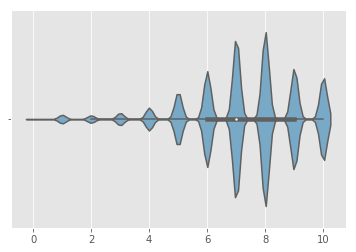

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.violinplot([ratingDF.Rating],palette="Blues")

In [0]:
from pyspark.ml.recommendation import ALS
(trainingRatings, testRatings) = mergeSQL.randomSplit([80.0, 20.0])
als = ALS(userCol="UserId", itemCol="MovieId", ratingCol="Rating",implicitPrefs=True,coldStartStrategy="drop")

ALSimplmodel = als.fit(trainingRatings)

In [22]:
imppredictions = ALSimplmodel.transform(testRatings)
imppredictions.show()

+-------+--------------------+----+------+------+------+------------+
|MovieId|               movie|year|UserId|Rating|scaled|  prediction|
+-------+--------------------+----+------+------+------+------------+
|  33717|        High Sierra |1941|  9147|     5|   1.0| 0.007404936|
|  33717|        High Sierra |1941| 57843|    10|   1.0| 0.032465257|
|  33717|        High Sierra |1941|  2852|     7|   0.0|3.0381285E-4|
|  33717|        High Sierra |1941| 44442|     5|   1.0|0.0075639253|
|  46521|        I vitelloni |1953|  5603|    10|   1.0| 0.124454625|
|  46521|        I vitelloni |1953| 53345|     7|   1.0|  0.21554318|
|  48254|      Killer's Kiss |1955| 26383|     6|   1.0| 0.025353149|
|  48254|      Killer's Kiss |1955| 32261|     7|   1.0| 0.020019263|
|  48254|      Killer's Kiss |1955| 45730|     7|   1.0|  0.07656854|
|  64519|       Doppelgänger |1969| 14504|     5|   1.0| -0.00168679|
|  70355|       Magnum Force |1973| 46938|     7|   1.0| 0.009288339|
|  70355|       Magn

In [39]:
ratingRDD = sqlCtx.createDataFrame(ratingDF)
ratingRDD = ratingRDD.selectExpr("UserId as user","MovieId as item","Rating as rating")
def split_sets(ratings, proportions):
    split = ratings.randomSplit(proportions, seed=42)
    return {'training': split[0], 'validation': split[1], 'test': split[2]}
    
sets = split_sets(ratingRDD, [0.63212056, 0.1839397, 0.1839397])
print("Training dataset size = {}".format(sets['training'].count()))
print("Validation dataset size = {}".format(sets['validation'].count()))
print("Test dataset size = {}".format(sets['test'].count()))

Training dataset size = 506226
Validation dataset size = 148042
Test dataset size = 147023


In [0]:
def calc_se(rating, user_factor, item_factor):
    """Squared Error (SE) for a single rating and prediction"""
    prediction = user_factor.T.dot(item_factor)
    return (rating - prediction) ** 2

In [40]:
sets['training'].show(10)

+----+-------+------+
|user|   item|rating|
+----+-------+------+
|   1| 454876|    10|
|   1| 790724|     8|
|   1| 882977|     8|
|   1|1229238|     9|
|   1|1288558|     5|
|   1|1483013|     6|
|   1|1583421|     7|
|   1|1588173|     9|
|   1|2024432|     8|
|   1|2053463|     8|
+----+-------+------+
only showing top 10 rows



In [41]:
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator

als = ALS(coldStartStrategy="drop")

param_grid = ParamGridBuilder() \
    .addGrid(als.rank, [6, 8]) \
    .addGrid(als.maxIter,[10, 12]) \
    .build()

evaluator = RegressionEvaluator(
    metricName="mse",
    labelCol="rating",
    predictionCol="prediction")

tvs = TrainValidationSplit(
    estimator=als,
    estimatorParamMaps=param_grid,
    evaluator=evaluator,
)

%time model = tvs.fit(sets['training'])

CPU times: user 658 ms, sys: 125 ms, total: 783 ms
Wall time: 1min 27s


In [42]:
print("Best rank = {}".format(model.bestModel.rank))
print("Best maxIter = {}".format(model.bestModel._java_obj.parent().getMaxIter()))

Best rank = 6
Best maxIter = 12


In [51]:
print(movieDF.head(5))
print(ratingDF.head(5))

   MovieId                                        Movie_Title
0        8      Edison Kinetoscopic Record of a Sneeze (1894)
1       10                La sortie des usines Lumière (1895)
2       12                      The Arrival of a Train (1896)
3       25  The Oxford and Cambridge University Boat Race ...
4       91                         Le manoir du diable (1896)
   UserId  MovieId  Rating
0       1   111161      10
1       1   117060       7
2       1   120755       6
3       1   317919       6
4       1   454876      10


In [53]:
prediction = model.transform(sets['test'])
movieRDD = sqlCtx.createDataFrame(movieDF)
# movieRDD = movieRDD.selectExpr("UserId as user","MovieId as item","Rating as rating")

prediction.alias('p').join(movieRDD.alias('m'), col('p.item') == col('m.item')) \
    .select([col('p.user'), col('m.title'), col('p.prediction'), col('p.rating')]).show(100, truncate=False)

NameError: ignored